In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

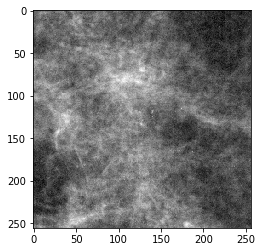

Label: [0. 0. 1. 0.]
[[[107.76470588 107.76470588 107.76470588]
  [103.25882353 103.25882353 103.25882353]
  [102.04705882 102.04705882 102.04705882]
  ...
  [ 88.36078431  88.36078431  88.36078431]
  [ 84.29019608  84.29019608  84.29019608]
  [ 91.03921569  91.03921569  91.03921569]]

 [[103.29411765 103.29411765 103.29411765]
  [102.80392157 102.80392157 102.80392157]
  [103.41960784 103.41960784 103.41960784]
  ...
  [ 89.4745098   89.4745098   89.4745098 ]
  [ 82.90196078  82.90196078  82.90196078]
  [ 85.52156863  85.52156863  85.52156863]]

 [[104.76862745 104.76862745 104.76862745]
  [100.86666667 100.86666667 100.86666667]
  [101.75294118 101.75294118 101.75294118]
  ...
  [ 85.47058824  85.47058824  85.47058824]
  [ 93.49019608  93.49019608  93.49019608]
  [ 88.58039216  88.58039216  88.58039216]]

 ...

 [[109.83137255 109.83137255 109.83137255]
  [106.73333333 106.73333333 106.73333333]
  [109.75686275 109.75686275 109.75686275]
  ...
  [ 92.09411765  92.09411765  92.0941176

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

In [13]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [14]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [15]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [17]:
vgg16_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [19]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 6.4830 - accuracy: 0.3041
Epoch 00001: val_loss improved from inf to 1.37344, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 6.2252 - accuracy: 0.3072 - val_loss: 1.3734 - val_accuracy: 0.3316
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3778 - accuracy: 0.3527
Epoch 00002: val_loss improved from 1.37344 to 1.34871, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3749 - accuracy: 0.3531 - val_loss: 1.3487 - val_accuracy: 0.3351
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3721 - accuracy: 0.3513
Epoch 00003: val_loss did not improve from 1.34871
19/19 [==============================] 

18/19 [===========================>..] - ETA: 1s - loss: 1.2436 - accuracy: 0.4217
Epoch 00027: val_loss did not improve from 1.20846
19/19 [==============================] - 29s 2s/step - loss: 1.2473 - accuracy: 0.4239 - val_loss: 1.2675 - val_accuracy: 0.4347
Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2383 - accuracy: 0.4580
Epoch 00028: val_loss did not improve from 1.20846
19/19 [==============================] - 29s 2s/step - loss: 1.2426 - accuracy: 0.4547 - val_loss: 1.2523 - val_accuracy: 0.4175
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2470 - accuracy: 0.4380
Epoch 00029: val_loss did not improve from 1.20846
19/19 [==============================] - 29s 2s/step - loss: 1.2430 - accuracy: 0.4432 - val_loss: 1.2630 - val_accuracy: 0.4433
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2425 - accuracy: 0.4408
Epoch 00030: val_loss did not improve from 1.20846
19/19 [==============================]

In [20]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [21]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [22]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [23]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 54
Epoch [opt]: 24
Valid accuracy [end]: 0.4433
Valid accuracy [opt]: 0.4261
Test accuracy [end]:  0.4687
Test accuracy [opt]:  0.4015
Valid loss [end]: 1.2489
Valid loss [opt]: 1.2085
Test loss [end]:  1.1975
Test loss [opt]:  1.2501


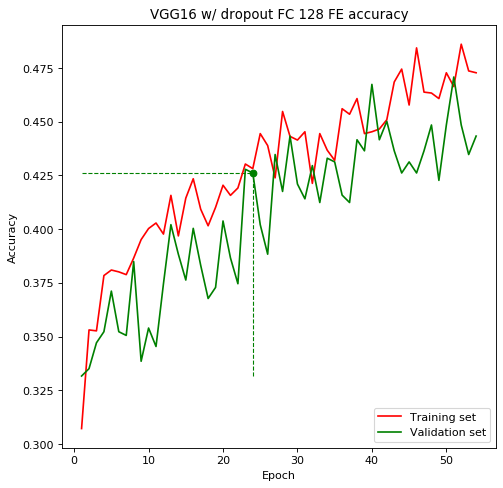

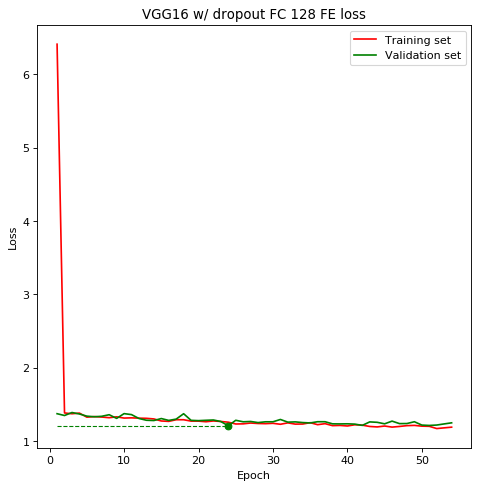

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [25]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 17.1893 - accuracy: 0.3168
Epoch 00001: val_loss improved from inf to 1.35608, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 16.3753 - accuracy: 0.3239 - val_loss: 1.3561 - val_accuracy: 0.3522
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3598 - accuracy: 0.3754
Epoch 00002: val_loss did not improve from 1.35608
19/19 [==============================] - 29s 2s/step - loss: 1.3641 - accuracy: 0.3715 - val_loss: 1.3594 - val_accuracy: 0.3299
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3654 - accuracy: 0.3740
Epoch 00003: val_loss improved from 1.35608 to 1.34609, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3721 - accuracy: 0.3762 - val_loss: 1.3461 - val_a

Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1994 - accuracy: 0.4780
Epoch 00029: val_loss did not improve from 1.23660
19/19 [==============================] - 29s 2s/step - loss: 1.2010 - accuracy: 0.4758 - val_loss: 1.2872 - val_accuracy: 0.4433
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2126 - accuracy: 0.4739
Epoch 00030: val_loss improved from 1.23660 to 1.22692, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.2141 - accuracy: 0.4728 - val_loss: 1.2269 - val_accuracy: 0.4467
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1714 - accuracy: 0.4898
Epoch 00031: val_loss did not improve from 1.22692
19/19 [==============================] - 29s 2s/step - loss: 1.1753 - accuracy: 0.4903 - val_loss: 1.2685 - val_accuracy: 0.4278
Epoch 32/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1939 - accuracy: 0.4798
Epoch 00032: val_loss did

In [27]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [28]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 79
Epoch [opt]: 49
Valid accuracy [end]: 0.4519
Valid accuracy [opt]: 0.4794
Test accuracy [end]:  0.4855
Test accuracy [opt]:  0.4656
Valid loss [end]: 1.2356
Valid loss [opt]: 1.2000
Test loss [end]:  1.1559
Test loss [opt]:  1.1842


In [33]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 10,749,700
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)      

In [20]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [23]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1336 - accuracy: 0.5164
Epoch 00001: val_loss improved from inf to 1.12361, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 23s 2s/step - loss: 1.1358 - accuracy: 0.5135 - val_loss: 1.1236 - val_accuracy: 0.5344
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1261 - accuracy: 0.5023
Epoch 00002: val_loss did not improve from 1.12361
11/11 [==============================] - 20s 2s/step - loss: 1.1254 - accuracy: 0.5036 - val_loss: 1.1761 - val_accuracy: 0.4914
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1514 - accuracy: 0.5004
Epoch 00003: val_loss improved from 1.12361 to 1.07382, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 19s 2s/step - loss: 1.1446 - accuracy: 0.5050 - val_loss: 1.0738 - val_accurac

10/11 [==========================>...] - ETA: 1s - loss: 1.0377 - accuracy: 0.5609
Epoch 00029: val_loss did not improve from 1.06883
11/11 [==============================] - 20s 2s/step - loss: 1.0423 - accuracy: 0.5554 - val_loss: 1.1502 - val_accuracy: 0.5344
Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 1.0387 - accuracy: 0.5581
Epoch 00030: val_loss did not improve from 1.06883
11/11 [==============================] - 20s 2s/step - loss: 1.0332 - accuracy: 0.5639 - val_loss: 1.0732 - val_accuracy: 0.5619
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 1.0258 - accuracy: 0.5602
Epoch 00031: val_loss did not improve from 1.06883
11/11 [==============================] - 21s 2s/step - loss: 1.0309 - accuracy: 0.5533 - val_loss: 1.0801 - val_accuracy: 0.5430
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 1.0442 - accuracy: 0.5516
Epoch 00032: val_loss improved from 1.06883 to 1.06324, saving model to vgg16_ft_1layer_4

10/11 [==========================>...] - ETA: 1s - loss: 0.9693 - accuracy: 0.5906
Epoch 00058: val_loss did not improve from 1.03490
11/11 [==============================] - 21s 2s/step - loss: 0.9699 - accuracy: 0.5909 - val_loss: 1.0876 - val_accuracy: 0.5601
Epoch 59/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9794 - accuracy: 0.5859
Epoch 00059: val_loss did not improve from 1.03490
11/11 [==============================] - 20s 2s/step - loss: 0.9737 - accuracy: 0.5859 - val_loss: 1.0561 - val_accuracy: 0.5739
Epoch 60/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9679 - accuracy: 0.5802
Epoch 00060: val_loss did not improve from 1.03490
11/11 [==============================] - 19s 2s/step - loss: 0.9747 - accuracy: 0.5777 - val_loss: 1.0700 - val_accuracy: 0.5447
Epoch 61/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9804 - accuracy: 0.5980
Epoch 00061: val_loss did not improve from 1.03490
11/11 [==============================]

Epoch 88/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9626 - accuracy: 0.5793
Epoch 00088: val_loss did not improve from 1.03219
11/11 [==============================] - 20s 2s/step - loss: 0.9707 - accuracy: 0.5746 - val_loss: 1.1310 - val_accuracy: 0.5172
Epoch 89/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9293 - accuracy: 0.6180
Epoch 00089: val_loss did not improve from 1.03219
11/11 [==============================] - 20s 2s/step - loss: 0.9185 - accuracy: 0.6190 - val_loss: 1.1007 - val_accuracy: 0.5533
Epoch 90/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9088 - accuracy: 0.6175
Epoch 00090: val_loss did not improve from 1.03219
11/11 [==============================] - 19s 2s/step - loss: 0.9178 - accuracy: 0.6151 - val_loss: 1.1480 - val_accuracy: 0.5498
Epoch 91/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9820 - accuracy: 0.5938
Epoch 00091: val_loss did not improve from 1.03219
11/11 [==================

Epoch 118/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8807 - accuracy: 0.6200
Epoch 00118: val_loss did not improve from 1.02154
11/11 [==============================] - 19s 2s/step - loss: 0.8920 - accuracy: 0.6190 - val_loss: 1.0302 - val_accuracy: 0.5739
Epoch 119/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9081 - accuracy: 0.6183
Epoch 00119: val_loss did not improve from 1.02154
11/11 [==============================] - 20s 2s/step - loss: 0.9109 - accuracy: 0.6205 - val_loss: 1.0269 - val_accuracy: 0.5911
Epoch 120/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9116 - accuracy: 0.6107
Epoch 00120: val_loss did not improve from 1.02154
11/11 [==============================] - 20s 2s/step - loss: 0.9121 - accuracy: 0.6106 - val_loss: 1.0460 - val_accuracy: 0.5756
Epoch 121/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9267 - accuracy: 0.6000
Epoch 00121: val_loss did not improve from 1.02154
11/11 [==============

Epoch 148/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8664 - accuracy: 0.6344
Epoch 00148: val_loss did not improve from 1.00812
11/11 [==============================] - 21s 2s/step - loss: 0.8729 - accuracy: 0.6364 - val_loss: 1.0513 - val_accuracy: 0.5601
Epoch 149/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8680 - accuracy: 0.6234
Epoch 00149: val_loss did not improve from 1.00812
11/11 [==============================] - 20s 2s/step - loss: 0.8707 - accuracy: 0.6243 - val_loss: 1.0188 - val_accuracy: 0.5704
Epoch 150/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8653 - accuracy: 0.6359
Epoch 00150: val_loss did not improve from 1.00812
11/11 [==============================] - 21s 2s/step - loss: 0.8687 - accuracy: 0.6349 - val_loss: 1.0893 - val_accuracy: 0.5481
Epoch 151/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8995 - accuracy: 0.6258
Epoch 00151: val_loss did not improve from 1.00812
11/11 [==============

In [24]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [25]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 153
Epoch [opt]: 123
Valid accuracy [end]: 0.5790
Valid accuracy [opt]: 0.5928
Test accuracy [end]:  0.5435
Test accuracy [opt]:  0.5496
Valid loss [end]: 1.0796
Valid loss [opt]: 1.0081
Test loss [end]:  1.1236
Test loss [opt]:  1.0939


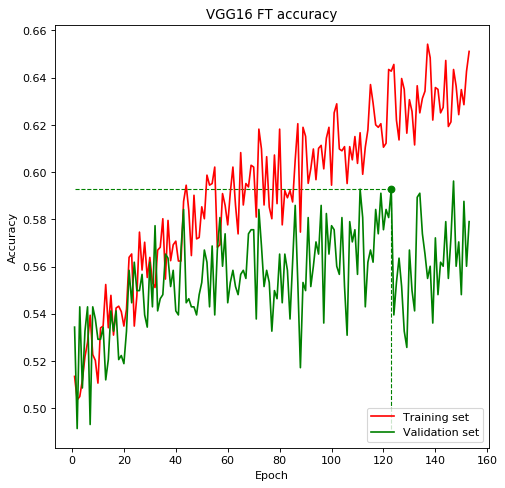

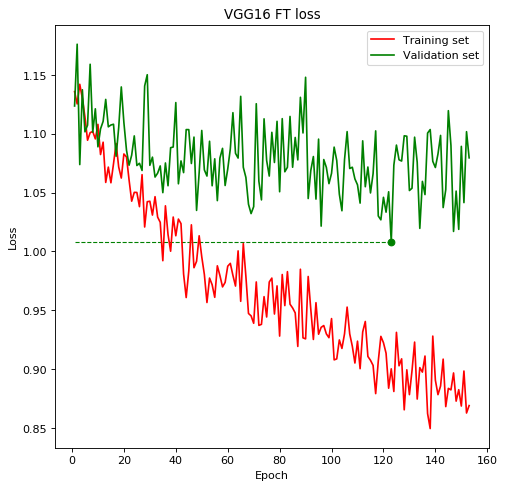

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [27]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [28]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [29]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2880 - accuracy: 0.5414
Epoch 00001: val_loss improved from inf to 1.05445, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 1.2658 - accuracy: 0.5419 - val_loss: 1.0544 - val_accuracy: 0.5687
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 1.0238 - accuracy: 0.5500
Epoch 00002: val_loss improved from 1.05445 to 1.04515, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0154 - accuracy: 0.5518 - val_loss: 1.0452 - val_accuracy: 0.5636
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 1.0136 - accuracy: 0.5750
Epoch 00003: val_loss did not improve from 1.04515
11/11 [==============================] - 20s 2s/step - loss: 1.0123 - accuracy: 0.5724 - val_loss: 1.1099 - val_accurac

Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8634 - accuracy: 0.6370
Epoch 00030: val_loss did not improve from 1.03824
11/11 [==============================] - 19s 2s/step - loss: 0.8817 - accuracy: 0.6305 - val_loss: 1.0964 - val_accuracy: 0.5584
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9014 - accuracy: 0.6250
Epoch 00031: val_loss did not improve from 1.03824
11/11 [==============================] - 21s 2s/step - loss: 0.9023 - accuracy: 0.6222 - val_loss: 1.0430 - val_accuracy: 0.5962
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 0.9139 - accuracy: 0.6200
Epoch 00032: val_loss improved from 1.03824 to 1.02332, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 0.9109 - accuracy: 0.6236 - val_loss: 1.0233 - val_accuracy: 0.5876
Epoch 33/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8685 - accuracy: 0.6514
Epoch 00033: val_loss did n

Epoch 59/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8477 - accuracy: 0.6387
Epoch 00059: val_loss did not improve from 1.00898
11/11 [==============================] - 19s 2s/step - loss: 0.8487 - accuracy: 0.6419 - val_loss: 1.0852 - val_accuracy: 0.5704
Epoch 60/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8197 - accuracy: 0.6624
Epoch 00060: val_loss improved from 1.00898 to 0.97870, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.8166 - accuracy: 0.6649 - val_loss: 0.9787 - val_accuracy: 0.6031
Epoch 61/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7991 - accuracy: 0.6687
Epoch 00061: val_loss did not improve from 0.97870
11/11 [==============================] - 21s 2s/step - loss: 0.7982 - accuracy: 0.6641 - val_loss: 0.9980 - val_accuracy: 0.6048
Epoch 62/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8049 - accuracy: 0.6582
Epoch 00062: val_loss did n

Epoch 89/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7529 - accuracy: 0.6692
Epoch 00089: val_loss did not improve from 0.97870
11/11 [==============================] - 20s 2s/step - loss: 0.7753 - accuracy: 0.6656 - val_loss: 1.0972 - val_accuracy: 0.5344
Epoch 90/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7889 - accuracy: 0.6898
Epoch 00090: val_loss did not improve from 0.97870
11/11 [==============================] - 21s 2s/step - loss: 0.7904 - accuracy: 0.6903 - val_loss: 1.1195 - val_accuracy: 0.5722
Epoch 00090: early stopping


In [30]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [31]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 90
Epoch [opt]: 60
Valid accuracy [end]: 0.5722
Valid accuracy [opt]: 0.6031
Test accuracy [end]:  0.5389
Test accuracy [opt]:  0.5573
Valid loss [end]: 1.1195
Valid loss [opt]: 0.9787
Test loss [end]:  1.2090
Test loss [opt]:  1.0685


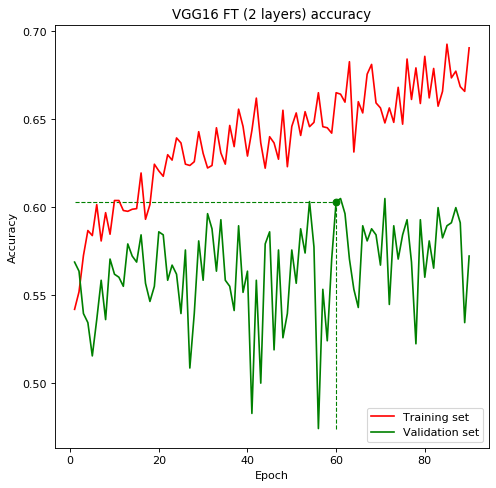

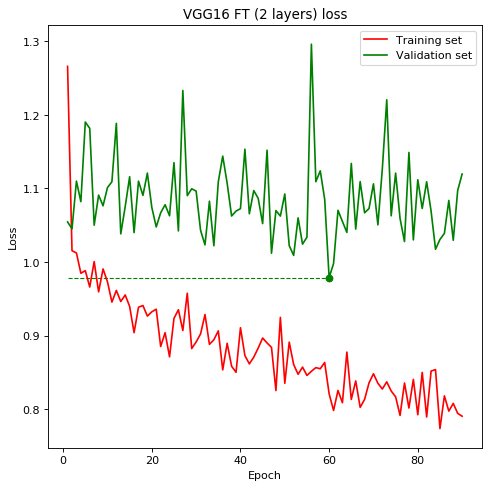

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [33]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 15,469,316
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [34]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [35]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7735 - accuracy: 0.6760
Epoch 00001: val_loss improved from inf to 1.12830, saving model to vgg16_ft_3layer_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 0.7679 - accuracy: 0.6817 - val_loss: 1.1283 - val_accuracy: 0.5584
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7569 - accuracy: 0.6879
Epoch 00002: val_loss improved from 1.12830 to 1.09298, saving model to vgg16_ft_3layer_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 0.7576 - accuracy: 0.6878 - val_loss: 1.0930 - val_accuracy: 0.5584
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7815 - accuracy: 0.6992
Epoch 00003: val_loss improved from 1.09298 to 1.00197, saving model to vgg16_ft_3layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7919 - 

Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 0.6765 - accuracy: 0.7167
Epoch 00030: val_loss did not improve from 1.00197
11/11 [==============================] - 19s 2s/step - loss: 0.6864 - accuracy: 0.7146 - val_loss: 1.0764 - val_accuracy: 0.5790
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7101 - accuracy: 0.6955
Epoch 00031: val_loss did not improve from 1.00197
11/11 [==============================] - 20s 2s/step - loss: 0.7184 - accuracy: 0.6963 - val_loss: 1.0126 - val_accuracy: 0.6186
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7013 - accuracy: 0.7133
Epoch 00032: val_loss did not improve from 1.00197
11/11 [==============================] - 20s 2s/step - loss: 0.7037 - accuracy: 0.7123 - val_loss: 1.0781 - val_accuracy: 0.5704
Epoch 33/200
10/11 [==========================>...] - ETA: 1s - loss: 0.6874 - accuracy: 0.7226
Epoch 00033: val_loss did not improve from 1.00197
11/11 [==================

In [36]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [37]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 33
Epoch [opt]: 3
Valid accuracy [end]: 0.5808
Valid accuracy [opt]: 0.6048
Test accuracy [end]:  0.5618
Test accuracy [opt]:  0.5786
Valid loss [end]: 1.0945
Valid loss [opt]: 1.0020
Test loss [end]:  1.2565
Test loss [opt]:  1.0498


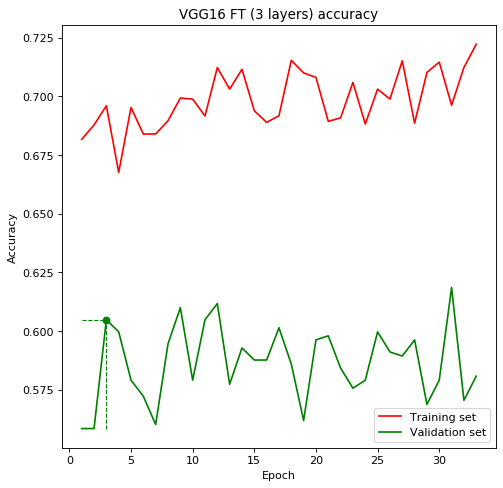

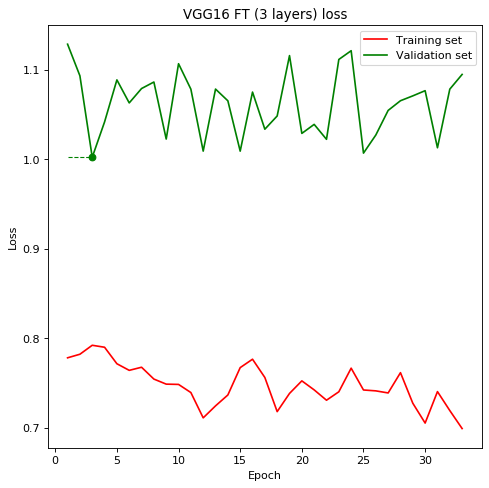

In [38]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();